# Machine Learning - Practical 4 - Deep Learning VS Trees


Names: Vinzenz Brehme, Dennis Exter, Miriam Reichlmaier  
Summer Term 2024   

In this practical we are going to use a tabular dataset. We will test two different approaches - forests and neural networks and compare performance. We are also going to learn how to make trees interpretable.

To prepare this tutorial we used [this paper](https://arxiv.org/pdf/2207.08815.pdf) with its [repository](https://github.com/LeoGrin/tabular-benchmark).

For explained variance in trees, you can read more [here](https://scikit-learn.org/0.15/auto_examples/ensemble/plot_gradient_boosting_regression.html#example-ensemble-plot-gradient-boosting-regression-py).


In [204]:
%matplotlib inline

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import recall_score, precision_score, accuracy_score

from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid
torch.manual_seed(42) # Set manual seed

In [205]:
# DO NOT CHANGE
use_cuda = True
use_cuda = False if not use_cuda else torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
torch.cuda.get_device_name(device) if use_cuda else 'cpu'
print('Using device', device)

Using device cpu


## Load, clean and split the tabular dataset

**Data description:**  
Predict whether income exceeds $50K/yr based on census data. Also known as "Census Income" dataset.  

Data is from https://archive.ics.uci.edu/dataset/2/adult

*Disclaimer* numbers below for Neural Networks, etc are outdated, so do not orient on these

**Task:** - download the dataset in python and load it here. Check the dataset size and preliminary artifacts.  

*Hint:*
* How many unique values the target column should have?

In [206]:
# TODO - download the dataset
# Using code provided on https://archive.ics.uci.edu/dataset/2/adult

# !pip install ucimlrepo

from ucimlrepo import fetch_ucirepo

# fetch dataset 
adult = fetch_ucirepo(name="Census Income") 
  
# data (as pandas dataframes) 
X = adult.data.features 
y = adult.data.targets 

dataset = X.join(y)

We use the preprocessing pipeline from [Grinsztajn, 2022](https://arxiv.org/pdf/2207.08815.pdf).

**No missing data**    

Remove all rows containing at least one missing entry.    

*In practice people often do not remove rows with missing values but try to fill missing values in a column with the mean or median values for numerical data and mode or median values for categorical data. Sometimes even simple prediction models are used to fill in the gaps but we will remove rows or columns with missing values for the sake of simplicity. Sometimes, even the fact that data is missing could be data itself (think about patients who came or missed doctor appointment). In this case we are going with the most simple way to handle Nans - basically removing such entries.*

**Balanced classes**   

For classification, the target is binarised if there are multiple classes, by taking the two most numerous classes, and we keep half of samples in each class.

**Low cardinality categorical features**   

Remove categorical features with more than 40 items.

**High cardinality numerical features**   

Remove numerical features with less than 10 unique values. Convert numerical features with 2 unique values to categorical.

**Encode categorical values**   

Use label encodings for categorical variables

*Hint:*
* To make t easier to drop rows with nan values, merge $X$ and $Y$ in the same dataframe

In [207]:
target_column = 'income'
test_size = 0.2
random_state = 42

In [208]:
def remove_nans(df):
    '''
    this fucntion removes rows with nans 
    '''
    # TODO
    df = df.dropna()

    return df


def numerical_to_categorical(df, n=2, ignore=[target_column]):
    '''
    change the type of the column to categorical 
    if it has <= n unique values
    '''
    # TODO

    df = df.copy()

    for col in df.select_dtypes(include='number'):
        # ignore columns
        if col in ignore:
            continue

        # amount of unique values in column
        nuniq = df[col].nunique()

        if nuniq <= n:
            df[col] = pd.Categorical(df[col])

    return df


def remove_columns_by_n(df, condition, n=10, direction='less', 
                        ignore=[target_column]):
    '''
   
    Remove columns with more or less than n unique values. 
    Usually it makes sense to apply this function to columns with categorical values (see below where it is called).
    With the default values we remove all numerical columns which have less than 10 unique values (except for the target_column).
    '''
    # TODO
    df = df.copy()

    drop_columns = []

    include_dtypes = condition if not condition is None else 'number'

    for col in df.select_dtypes(include=include_dtypes):
        # ignore columns
        if col in ignore:
            continue

        # amount of unique values in column
        nuniq = df[col].nunique()

        # check if drop condition is fulfilled
        if direction == 'less' and nuniq < n:
            drop_columns.append(col)
        elif direction == 'more' and nuniq > n:
            drop_columns.append(col)

    # drop columns
    df = df.drop(columns=drop_columns)
            
    return df

def object_to_categorical(df):
    '''
    Make columns with the 'object' type categorical 
    and replace categories with label encodings
    '''
    # TODO
    df = df.copy()

    for col in df.select_dtypes(include='object'):
        # Make columns with 'object' type categorical
        df[col] = pd.Categorical(df[col])

        # Replace catogories with label encodings
        df[col] = df[col].cat.codes

    return df

In [307]:
# Replace wrong class representations in the target column
dataset.loc[dataset[target_column] == '<=50K.', target_column] = "<=50K"
dataset.loc[dataset[target_column] == '>50K.', target_column] = ">50K"

In [210]:
dataset[target_column].value_counts()

income
<=50K    37155
>50K     11687
Name: count, dtype: int64

In [211]:
df = dataset
df_before = dataset
df = remove_nans(df)
df = numerical_to_categorical(df, n=2, ignore=[target_column])

df = remove_columns_by_n(df, n=10, direction='less',
                         ignore=[target_column], condition=None)
df = object_to_categorical(df)
df = remove_columns_by_n(df, n=40, direction='more', 
                         ignore=[target_column], condition='category')
assert not df.isna().any().any(), 'There are still nans in the dataframe'

In [212]:
df.head()

age  workclass  fnlwgt  education  education-num  marital-status  \
0   39          7   77516          9             13               4   
1   50          6   83311          9             13               2   
2   38          4  215646         11              9               0   
3   53          4  234721          1              7               2   
4   28          4  338409          9             13               2   

   occupation  relationship  race  sex  capital-gain  capital-loss  \
0           1             1     4    1          2174             0   
1           4             0     4    1             0             0   
2           6             1     4    1             0             0   
3           6             0     2    1             0             0   
4          10             5     2    0             0             0   

   hours-per-week  native-country  income  
0              40              39       0  
1              13              39       0  
2              40              39       0  
3              40              39       0  
4              40               5       0

In [213]:
#most_num_targets = df[target_column].value_counts().iloc[0:2].index

#df = df.loc[df[target_column].isin(most_num_targets)]

In [214]:
# Use only half of the data of each class for the samples
sampled_dfs = []

for group in df.groupby(target_column):
    sampled_dfs.append(group[1].sample(frac=0.5, random_state=random_state))

df = pd.concat(sampled_dfs).reset_index(drop=True)

In [215]:
df[target_column].value_counts()

income
0    18040
1     5770
Name: count, dtype: int64

In [216]:
df.head()

age  workclass  fnlwgt  education  education-num  marital-status  \
0   35          6   37778          8             11               2   
1   39          7  318918          9             13               2   
2   22          5  437161         11              9               4   
3   51          4  186299         13              1               4   
4   17          4  103851          1              7               4   

   occupation  relationship  race  sex  capital-gain  capital-loss  \
0           5             0     4    1          3103             0   
1           4             0     4    1             0             0   
2           1             4     2    0             0             0   
3           7             1     4    1             0             0   
4           1             3     4    0          1055             0   

   hours-per-week  native-country  income  
0              55              39       0  
1              40              39       0  
2              40              39       0  
3              30              39       0  
4              20              39       0

In [309]:
# Convert all values to long
for column in df.columns:
    df[column] = df[column].astype("int64")

In [310]:
# TODO : make train-test split from the dataframe using the parameters above
# expected results variable names - train_X, test_X, train_y, test_y

X = df.drop(columns=target_column)
Y = df[target_column]

print(X.head())
print(Y.head())

train_X, test_X, train_y, test_y = train_test_split(X, 
                                                    Y, 
                                                    random_state=random_state, 
                                                    test_size=test_size, 
                                                    shuffle=True, 
                                                    stratify=Y
                                                   )

   age  workclass  fnlwgt  education  education-num  marital-status  \
0   35          6   37778          8             11               2   
1   39          7  318918          9             13               2   
2   22          5  437161         11              9               4   
3   51          4  186299         13              1               4   
4   17          4  103851          1              7               4   

   occupation  relationship  race  sex  capital-gain  capital-loss  \
0           5             0     4    1          3103             0   
1           4             0     4    1             0             0   
2           1             4     2    0             0             0   
3           7             1     4    1             0             0   
4           1             3     4    0          1055             0   

   hours-per-week  native-country  
0              55              39  
1              40              39  
2              40              39  
3       

In [311]:
train_X.shape

(19048, 14)

**TODO :**  

* Did you split the dataset in a stratified manner or not? Why?  
Yes we split the dataset in a stratified manner to keep the proportions of the target features. One class has about 75% of samples and the other about 25%.
* How did the dataset dimensions change after preprocessing?
* How many unique values are in the target variable? 

In [219]:
# dataset dimensions
print(f"dimensions before preprocessing = {df_before.shape}")
print(f"dimensions after preprocessing = {df.shape}")
print(f"number of deleted rows = {(df_before.shape[0]) - (df.shape[0])}")

# target variable unique values
Y_unique = np.unique(Y)
print(Y_unique.shape)
print(Y_unique)

dimensions before preprocessing = (48842, 15)
dimensions after preprocessing = (23810, 15)
number of deleted rows = 25032
(2,)
[0 1]


## Task 1: Create a GradientBoostingClassifier

In [75]:
## TODO : define the GradientBoostingClassifier, 
## train it on the train set and predict on the test set
clf = GradientBoostingClassifier()
clf.fit(train_X, train_y)
y_pred = clf.predict(test_X)

In [76]:
## TODO : print  accuracy, precision, recall
## Hint : use functions from sklearn metrics
def print_scores(test_y, y_pred):
    print(f"accuracy = {accuracy_score(test_y, y_pred)}")
    print(f"precision = {precision_score(test_y, y_pred, average='weighted', zero_division=1)}")
    print(f"recall = {recall_score(test_y, y_pred, average='weighted')}")
    print()

In [77]:
print_scores(test_y, y_pred)

accuracy = 0.8622427551448971
precision = 0.8566158732544936
recall = 0.8622427551448971



In [78]:
## TODO : Write a function which iterates over trees_amount, 
## train a classifier with a specified amount of trees and print accuracy, precision, and recall.
## Note: the calculations may take several minutes (depending on the computer efficiency).

def trees_amount_exploration(train_X, train_y, test_X, test_y, trees_amount=[1, 20, 50, 100]):
    for i in range(len(trees_amount)):
        clf = GradientBoostingClassifier(n_estimators=trees_amount[i])
        clf.fit(train_X, train_y)
        y_pred = clf.predict(test_X)
        print(f"score values for tree_amount[{trees_amount[i]}]")
        print_scores(test_y, y_pred)


In [79]:
trees_amount_exploration(train_X, train_y, test_X, test_y)

score values for tree_amount[1]
accuracy = 0.7576648467030659
precision = 0.8163911732265144
recall = 0.7576648467030659

score values for tree_amount[20]
accuracy = 0.8555228895422091
precision = 0.8525255744624413
recall = 0.8555228895422091

score values for tree_amount[50]
accuracy = 0.8603527929441411
precision = 0.8553584781552878
recall = 0.8603527929441411

score values for tree_amount[100]
accuracy = 0.8622427551448971
precision = 0.8566158732544936
recall = 0.8622427551448971



In [80]:
## TODO : Write a function which iterates over the learning rate, 
## train a classifier with a specified amount of trees and print accuracy, precision, and recall.
## Note: the calculations may take several minutes (depending on the computer efficiency).

def learning_rate_exploration(train_X, train_y, test_X, test_y, learning_rates = [0.1, 0.2, 0.3, 0.4, 0.5], trees_amount=100):
    for i in range(len(learning_rates)):
        clf = GradientBoostingClassifier(learning_rate=learning_rates[i])
        clf.fit(train_X, train_y)
        y_pred = clf.predict(test_X)    
        print(f"score values for learning_rate[{learning_rates[i]}]")
        print_scores(test_y, y_pred)

In [81]:
learning_rate_exploration(train_X, train_y, test_X, test_y)

score values for learning_rate[0.1]
accuracy = 0.8622427551448971
precision = 0.8566158732544936
recall = 0.8622427551448971

score values for learning_rate[0.2]
accuracy = 0.862662746745065
precision = 0.8572173774131445
recall = 0.862662746745065

score values for learning_rate[0.3]
accuracy = 0.863292734145317
precision = 0.8579729987212616
recall = 0.863292734145317

score values for learning_rate[0.4]
accuracy = 0.8649727005459891
precision = 0.8599848396661616
recall = 0.8649727005459891

score values for learning_rate[0.5]
accuracy = 0.8609827803443931
precision = 0.8560915659157172
recall = 0.8609827803443931



In [89]:
## TODO : Write a function which iterates over different depths, 
## train a classifier with a specified depth and print accuracy, precision, and recall
## Set trees_amount= 50 to make the calculations faster
## Note: the calculations may take several minutes (depending on the computer efficiency).

def max_depth_exploration(train_X, train_y, test_X, test_y, depths=[1,2,3,5]):
    for i in range(len(depths)):
        clf = GradientBoostingClassifier(max_depth=depths[i], n_estimators=50)
        clf.fit(train_X, train_y)
        y_pred = clf.predict(test_X)    
        print(f"score values for depth[{depths[i]}]")
        print_scores(test_y, y_pred)

In [90]:
max_depth_exploration(train_X, train_y, test_X, test_y)

score values for depth[1]
accuracy = 0.8422931541369173
precision = 0.8434190206010108
recall = 0.8422931541369173

score values for depth[2]
accuracy = 0.8546829063418732
precision = 0.8497444217951444
recall = 0.8546829063418732

score values for depth[3]
accuracy = 0.8603527929441411
precision = 0.8553584781552878
recall = 0.8603527929441411

score values for depth[5]
accuracy = 0.8624527509449811
precision = 0.8568469649865897
recall = 0.8624527509449811



**TODO :**   

* How does the max_depth parameter influence the results? 
* How does the learning rate influence the results?
* How does the number of trees in the ensemble influence the results?
* Try to improve the accuracy by combining different max_depth, learning rate and number of trees. How well does your best model perform?

In [305]:
accuracy_values = []

def calc_accuracy(train_X, train_y, test_X, test_y):
    trees_amount=[1, 20, 50, 100]
    depths = [1,2,3,5]
    learning_rates = [0.1, 0.2, 0.3, 0.4, 0.5]


    for tree_amnt in tqdm(trees_amount, desc='tree amount'):
        for depth in tqdm(depths, desc='depth', leave=False):
            for lr in tqdm(learning_rates, desc='learning rate', leave=False):
                clf = GradientBoostingClassifier(learning_rate=lr, n_estimators=tree_amnt, max_depth=depth)
                clf.fit(train_X, train_y)
                y_pred = clf.predict(test_X)
                accuracy = accuracy_score(test_y, y_pred=y_pred)
                accuracy_values.append((accuracy, tree_amnt, depth, lr))

calc_accuracy(train_X, train_y, test_X, test_y)

tree amount:   0%|          | 0/4 [00:00<?, ?it/s]

depth:   0%|          | 0/4 [00:00<?, ?it/s]

learning rate:   0%|          | 0/5 [00:00<?, ?it/s]

learning rate:   0%|          | 0/5 [00:00<?, ?it/s]

learning rate:   0%|          | 0/5 [00:00<?, ?it/s]

learning rate:   0%|          | 0/5 [00:00<?, ?it/s]

depth:   0%|          | 0/4 [00:00<?, ?it/s]

learning rate:   0%|          | 0/5 [00:00<?, ?it/s]

learning rate:   0%|          | 0/5 [00:00<?, ?it/s]

learning rate:   0%|          | 0/5 [00:00<?, ?it/s]

learning rate:   0%|          | 0/5 [00:00<?, ?it/s]

depth:   0%|          | 0/4 [00:00<?, ?it/s]

learning rate:   0%|          | 0/5 [00:00<?, ?it/s]

learning rate:   0%|          | 0/5 [00:00<?, ?it/s]

learning rate:   0%|          | 0/5 [00:00<?, ?it/s]

learning rate:   0%|          | 0/5 [00:00<?, ?it/s]

depth:   0%|          | 0/4 [00:00<?, ?it/s]

learning rate:   0%|          | 0/5 [00:00<?, ?it/s]

learning rate:   0%|          | 0/5 [00:00<?, ?it/s]

learning rate:   0%|          | 0/5 [00:00<?, ?it/s]

learning rate:   0%|          | 0/5 [00:00<?, ?it/s]

In [306]:
accuracy_values.sort(reverse=True)
accuracy_values

[(0.8656026879462411, 20, 5, 0.3),
 (0.8649727005459891, 100, 3, 0.4),
 (0.8647627047459051, 100, 5, 0.3),
 (0.864552708945821, 50, 5, 0.2),
 (0.8643427131457371, 100, 5, 0.2),
 (0.8643427131457371, 20, 5, 0.5),
 (0.8635027299454011, 50, 3, 0.3),
 (0.863292734145317, 100, 3, 0.3),
 (0.8630827383452331, 100, 5, 0.1),
 (0.8630827383452331, 100, 2, 0.4),
 (0.8630827383452331, 50, 5, 0.3),
 (0.8628727425451491, 100, 2, 0.3),
 (0.862662746745065, 50, 5, 0.1),
 (0.862662746745065, 50, 3, 0.4),
 (0.8622427551448971, 100, 3, 0.2),
 (0.8622427551448971, 100, 3, 0.1),
 (0.862032759344813, 100, 2, 0.2),
 (0.8616127677446451, 20, 3, 0.5),
 (0.8614027719445612, 20, 5, 0.4),
 (0.8614027719445612, 20, 5, 0.2),
 (0.8611927761444771, 100, 2, 0.1),
 (0.8611927761444771, 50, 3, 0.5),
 (0.8609827803443931, 50, 5, 0.4),
 (0.8609827803443931, 50, 2, 0.4),
 (0.8609827803443931, 20, 3, 0.3),
 (0.8607727845443092, 20, 3, 0.4),
 (0.8605627887442251, 100, 3, 0.5),
 (0.8605627887442251, 50, 2, 0.2),
 (0.860142797

In [91]:
## TODO -  sklearn trees have the attribute feature_importances_
## make a plot, to show relative importance (maximum is 1) of your classifier and
## order features from most relevant feature to the least relevant in the plot

def plot_explained_variance(clf, X):
    # TODOd
    importances = clf.feature_importances_
    indices = np.argsort(importances)[::-1]

    # Generieren von Platzhalter-Feature-Namen
    feature_names = [column for column in df.iloc[:-1]]

    plt.figure(figsize=(10, 6))
    plt.title('Feature Importances')
    plt.bar(range(len(importances)), importances[indices], align='center')
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.show()

In [92]:
## TODO : display the plot
plot_explained_variance(clf, X)

**TODO :** Interpret the plot.

**TODO (optional):** Try to remove the least-important features and see what happens. Does to quality improve or degrade? Why? 

## [OPTIONAL] Implement Tree from scratch


In [23]:
n_samples = 100000 # our implementation took ~1 min with this amount of samples, you can reduce the number if neccessary
X_train, X_test, y_train, y_test = train_X.to_numpy()[:n_samples], test_X.to_numpy(), train_y.to_numpy()[:n_samples], test_y.to_numpy()


Next, we will implement a simple decision tree classifier ourselves.
We will use the Gini impurity as a criterion for splitting. It is defined for a set of labels as
$$ G = \sum_{i=0}^C p(i) * (1- p(i)) $$

Given labels $l$ and split in $l_a$ and $l_b$, the weighted removed impurity can be computed by $G(l) - \frac{|l_a|}{|l|}G(l_a) - \frac{|l_b|}{|l|}G(l_b)$.

Here is a simple explanation of the Gini impurity that you may find useful: https://victorzhou.com/blog/gini-impurity/


### Task 2.1

1. Implement a function `gini_impurity(y)` that computes the Gini impurity for an array of labels `y`.
2. Implement a function `weighted_difference(y, split)`, that calculates the removed Gini impurity for a given boolean array `split` and `y`.
3. Implement a function `find_best_split`, that performs an exhaustive search over all possible splits, i.e. for all features in x and all values of these features. 

Note: We have converted the training data to numpy above. Please use these arrays for the task. During debugging, it might be a good idea to reduce the number of data points via the n_samples argument above to speed up computations.

In [24]:
# TODO: Implement the functions gini_impurity and weighted_difference

def gini_impurity(y, labels=(0, 1)):
    proba_sum = 0
    for label in labels:
        label_cnt = 0
        for i in y:
            if i == label:
                label_cnt += 1 
        label_proba = label_cnt / len(y)
        proba_sum += label_proba
    return proba_sum

# was ist la und lb genau?
def weighted_difference(y, split, labels=(0, 1)):
    gini = gini_impurity(y, labels)
    pass
    

In [25]:
# example application
print(gini_impurity(y_train, labels=(0, 1)))
split = X_train[:,0] < 40
print(weighted_difference(y_train, split))

print(split[:10])



1.0
None
[ True  True False  True False False False False False False]


In [26]:
# TODO: Implement the function find_best_split
def exhaustive_search(x, y):
    pass

def find_best_split(impurities_array, midpoints_array, features_array, verbose=False):
    pass

In [27]:
# plotting functionality, works only if you have computed midpoints_array, impurities_array, features_array

#fig, ax = plt.subplots(4, 4, figsize=(14, 10), squeeze=False)
#ax = ax.flatten()

#for i in range(14):
    #select_feature = features_array == i
    #impurities_feature = impurities_array[select_feature]
    #midpoints_feature = midpoints_array[select_feature]
    
    #if i < len(ax):
        #ax[i].scatter(midpoints_feature, impurities_feature, s=4)
        #ax[i].set_title(f'Feature {i}')
    #ax[i].set_xlabel('Split Value')
    #ax[i].set_ylabel('Impurity Reduction')

## Hide unused axes if any
#for j in range(i + 1, len(ax)):
    #ax[j].axis('off')

#plt.tight_layout()
#plt.show()

### Task 2.3

1. Implement a function `build_tree(X, t, depth)` which recursively builds a tree. Use the classes `Node` and `Leaf` as a data structure to build your tree.
2. Implement a function `predict_tree(tree, x)` which makes a prediction for sample `x`. Obtain scores for the `wine` dataset and compare to `sklearn.tree.DecisionTree`.


In [28]:
class Node:
    def __init__(self, left, right, n_feat, threshold):
        self.left = left
        self.right = right
        self.n_feat = n_feat
        self.threshold = threshold


class Leaf:
    def __init__(self, label):
        self.label = label

In [29]:
# TODO: implement the function build_tree and predict_tree

# Implement recursive tree function
def build_tree(x, y, current_depth, max_depth=3, n_labels=2):
    pass


def predict_tree(node, x):
    pass

In [30]:
# Build tree
tree = build_tree(X_train, y_train, current_depth=0, max_depth=3, n_labels=2)
predictions = predict_tree(tree, X_test)
predictions

In [31]:
# Calculate training and test scores
#print('Accuracy Training: ', accuracy_score(y_train, predict_tree(tree, X_train)))
#print('Accuracy: ', accuracy_score(test_y, predictions))
#print('Precision: ', precision_score(test_y, predictions, average='macro'))
#print('Recall: ', recall_score(test_y, predictions, average='macro'))

## Prepare for deep learning
### Add all the necessary training functions 
*You can reuse them from previous practical exercises*

In [220]:
## TODO write a function that calculates the accuracy
## Hint - you can use yours from practical 3 

def accuracy(correct, total): 
    """
    function to calculate the accuracy given the
        correct: number of correctly classified samples
        total: total number of samples
    returns the ratio
    """
    ratio = correct/total
    return ratio

In [221]:
## TODO : Define a train and validation functions here
## Hint - you can use yours from practical 3 
from tqdm.notebook import tqdm

def train(dataloader, optimizer, model, loss_fn, device, master_bar):
    """ method to train the model """
    model.train()
    train_losses = []
    train_correct = 0
    train_total = 0 
    for x_batch, target in tqdm(dataloader, desc='Training', leave=False):
        x_batch = x_batch.to(device)
        target = target.to(device)
        pred = model(x_batch)
        loss = loss_fn(pred, target)
        train_losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(pred.data, 1) 
        train_total += target.size(0)        
        train_correct += (predicted == target).sum().item() 
    
    train_loss = sum(train_losses)/len(dataloader)
    train_acc = accuracy(train_correct, train_total)
    return train_loss, train_acc 


def validate(dataloader, model, loss_fn, device, master_bar):
    """ method to compute the metrics on the validation set """
    model.eval()
    val_losses = []
    val_total = 0
    val_correct = 0
    for x_batch, target in tqdm(dataloader, desc='Validation', leave=False):
        x_batch = x_batch.to(device)
        target = target.unsqueeze(1)[:,0].to(device)

        pred = model(x_batch)
        loss = loss_fn(pred, target)
        val_losses.append(loss.item())
        _, predicted = torch.max(pred.data, 1)
        val_total += target.size(0)
        val_correct += (predicted == target).sum().item() 

    val_loss = sum(val_losses)/len(dataloader)
    val_acc = accuracy(val_correct, val_total)
    return val_loss, val_acc

In [222]:
#TODO write a run_training function that 
# - calls the train and validate functions for each epoch
# - saves the train_losses, val_losses, train_accs, val_accs as arrays for each epoch
## Hint - you can use yours from practical 3 
from tqdm.notebook import trange


def run_training(model, optimizer, loss_function, device, num_epochs, train_dataloader, val_dataloader):
    """ method to run the training procedure """
    # - saves the train_losses, val_losses, train_accs, val_accs as arrays for each epoch

    lr=0.001

    # TODO: implement master_bar
    master_bar = None

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    for _ in trange(num_epochs, desc="Train epoch"):
        train_loss, train_acc = train(train_dataloader, optimizer, model, loss_function, device, master_bar)
        val_loss, val_acc = validate(val_dataloader, model, loss_function, device, master_bar)
        train_losses.append(train_loss)
        val_losses.append(val_loss) 
        train_accs.append(train_acc)
        val_accs.append(val_acc)

    return train_losses, val_losses, train_accs, val_accs

In [223]:
# TODO write a plot_model_progress function 
## It should plot epochs vs metric progress 
## Hint - you can use yours from practical 2 or 3 
def plot_model_progress(train_losses, val_losses, epochs, loss=True, network_name='Network'):
    epochs_range = range(epochs)
    label_str = ""
    
    if (loss):
        label_str = "Loss"
    else:
        label_str = "Accuracy"
        
    plt.plot(epochs_range, train_losses, marker="o", color="blue", linestyle="-", label="Train " + label_str) 
    plt.plot(epochs_range, val_losses, marker="o", color="orange", linestyle="-", label="Validation " + label_str)
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel(label_str)
    plt.xticks(epochs_range)
    plt.title(network_name + ": Epoch vs " + label_str)
    plt.show()

### Convert a pandas dataframe to a PyTorch dataset

In [224]:
## TODO : Define the dataset, apply normalization in the getitem method
## Hint : you can use/adapt your code from practical 2
class TabularDataset(torch.utils.data.Dataset):
    def __init__(self, df_x, df_y, mean=None, std=None, normalise=True):
        '''
        TODO: save params to self attributes, 
        x is data without target column
        y is target column
        transform df to_numpy
        ''' 
        numpy_y = df_y.to_numpy()
        numpy_x = df_x.to_numpy()
        #self.target_column=target_clm
        self.df_x = numpy_x
        self.df_y = numpy_y
        self.mean = np.mean(numpy_x)
        self.std = np.std(numpy_x)
        self.normalise = normalise
    
    def __len__(self):
        # TODO: return the length of the whole dataset
        return len(self.df_x)

    
    def __getitem__(self, index):
        ## TODO: return X, y by index, normalized if needed
        data = self.df_x[index]
        if self.normalise and self.mean is not None and self.std is not None:
            data = (data - self.mean) / self.std
        return data, self.df_y[index]

In [225]:
## TODO : calculate mean and std for the train set
## Hint : be careful with categorical values. Convert them them to numerical 
## Hint : the response variable should be of datatype integer

#scheck for categorical values
#train_X.dtypes

mean = train_X.mean()
#print('Mean:  \n'+ str(mean))
std = train_X.std()
#print('Std: \n' + str(std))

In [226]:
# TODO : define new datasets with mean, std and normalise=True
# be careful with the labels, they should start from 0
batch_size = 256
generator = torch.Generator()

normalised_train = TabularDataset(train_X, train_y, mean, std, normalise=True)
normalised_test = TabularDataset(test_X, test_y, mean, std, normalise=True)

epoch_train_X, epoch_val_X=torch.utils.data.random_split(dataset=normalised_train, lengths=[0.9,0.1], generator=generator)

train_loader = DataLoader(epoch_train_X, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(epoch_val_X,   batch_size=batch_size)


## Logistic regression

In [227]:
class LR(torch.nn.Module):
    """
    The logistic regression model inherits from torch.nn.Module 
    which is the base class for all neural network modules.
    """
    def __init__(self, input_dim, output_dim):
        """ Initializes internal Module state. """
        super(LR, self).__init__()
        # TODO define linear layer for the model
        self.linear = nn.Linear(input_dim, output_dim)
        

    def forward(self, x):
        """ Defines the computation performed at every call. """
        # What are the dimensions of your input layer?
        # TODO manipulation of data format needed?
        x = x.to(torch.float32)
        x = torch.flatten(x, 1)
        
        # run the data through the layer
        output = self.linear(x)

        # The used loss function (CrossEntropyLoss) contains the sigmoid call

        return output

In [229]:
import torch.optim as optim
from torch.utils.data import TensorDataset
## TODO define model, loss and optimizers
## don't forget to move everything for the correct devices
##

input_dim = 14
output_dim = 2

# define model, loss and optimizer from last practical
lr=0.01
loss = nn.CrossEntropyLoss()
model = LR(input_dim=input_dim, output_dim=output_dim)
optimizer = optim.Adam(model.parameters(), lr=lr)



In [169]:
## TODO train the network
num_epochs = 30
train_losses, val_losses, train_accs, val_accs = run_training(model, optimizer, loss, device, num_epochs, train_loader, val_loader)

Train epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

In [170]:
## todo - plot epochs vs loss with plot_model_progress
plot_model_progress(train_losses, val_losses, num_epochs)

In [171]:
## todo - plot epochs and accuracy with plot_model_progress
plot_model_progress(train_accs, val_accs, num_epochs)

In [236]:
lrs = np.linspace(0.1, 0.01, num=20)

num_epochs = 30

values = []

for lr in tqdm(lrs, desc='Learning rate'):
    loss = nn.CrossEntropyLoss()
    model = LR(input_dim=input_dim, output_dim=output_dim)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, val_losses, train_accs, val_accs = run_training(model, optimizer, loss, device, num_epochs, train_loader, val_loader)

    d = {}

    d['lr'] = lr
    d['epochs'] = num_epochs
    d['train_losses'] = train_losses
    d['val_losses'] = val_losses
    d['train_accs'] = train_accs
    d['val_accs'] = val_accs

    values.append(d)


Learning rate:   0%|          | 0/20 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Train epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

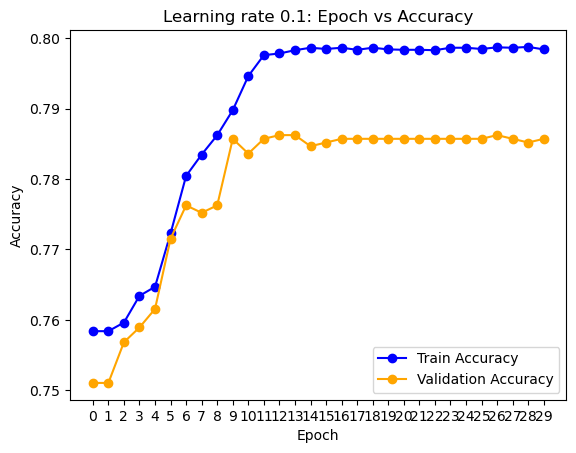

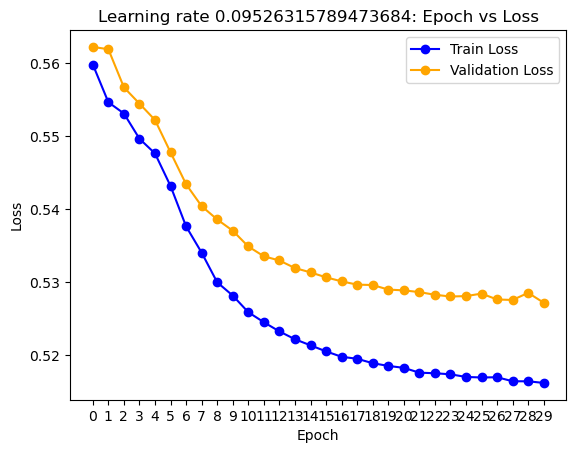

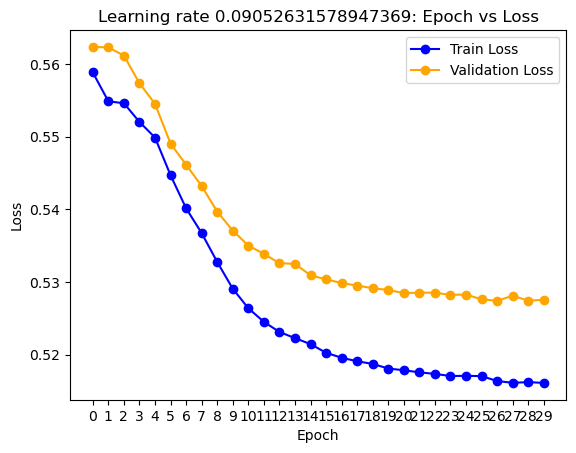

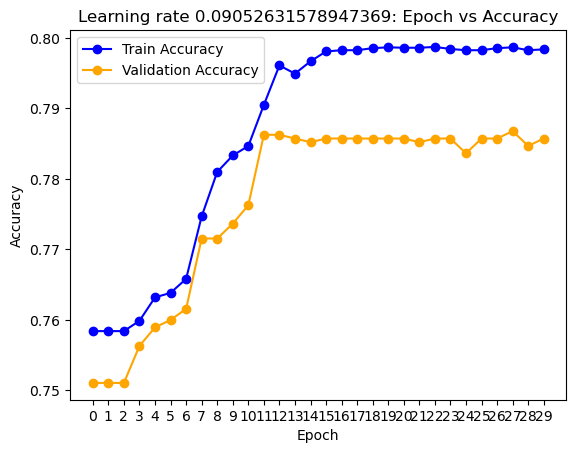

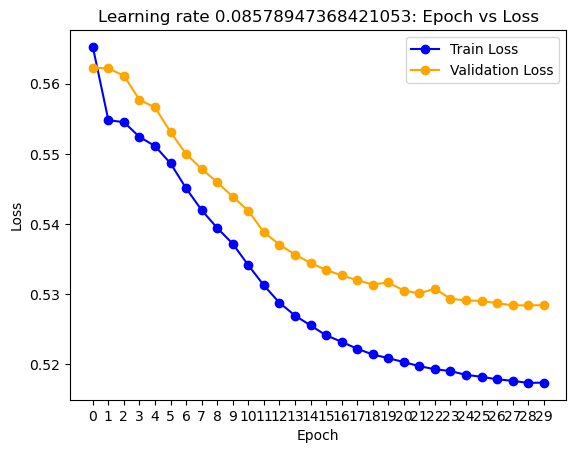

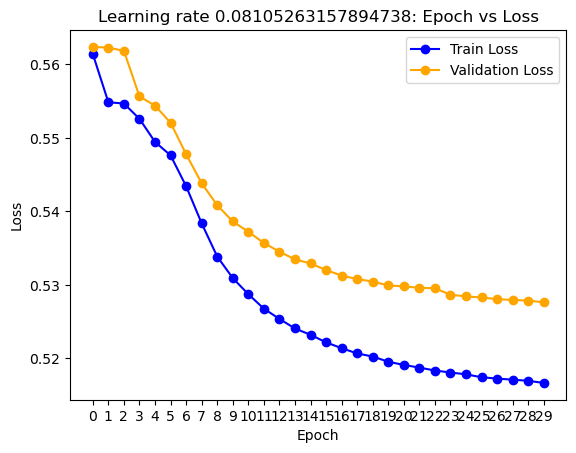

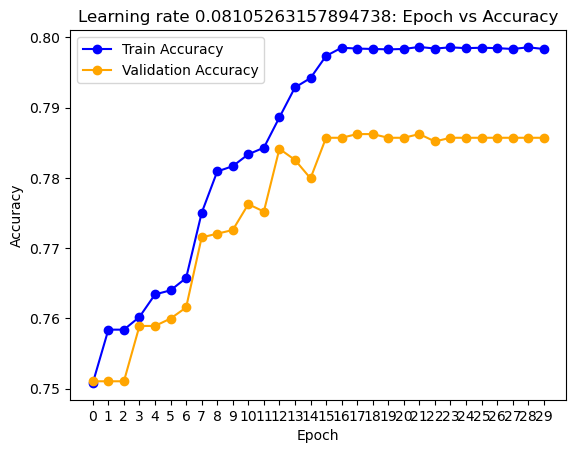

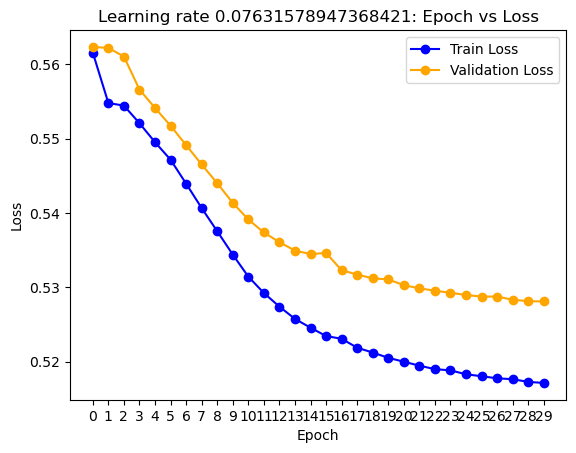

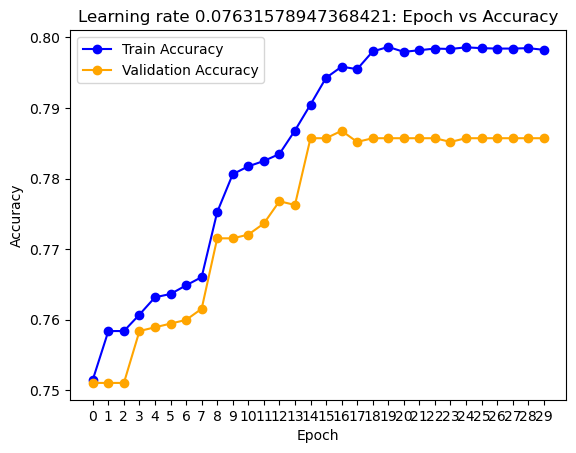

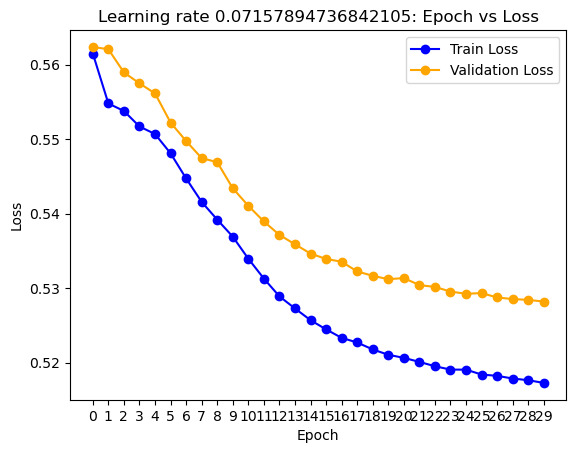

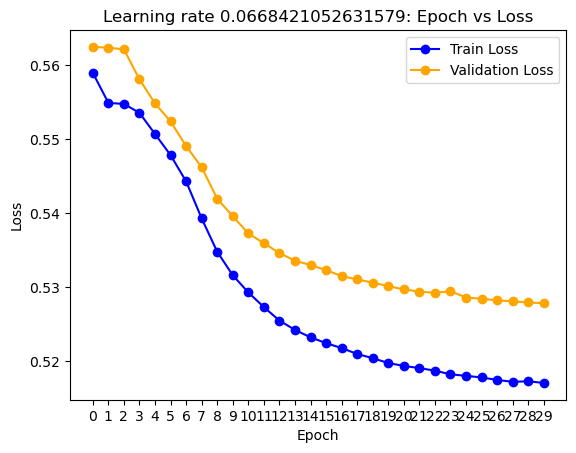

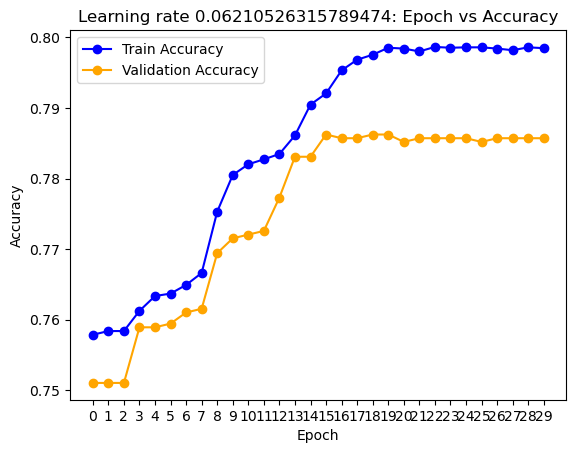

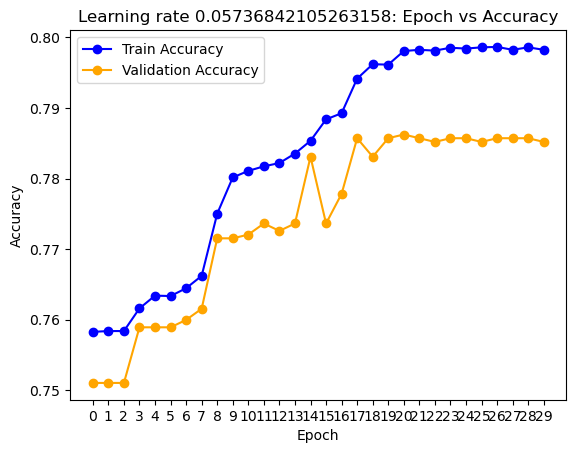

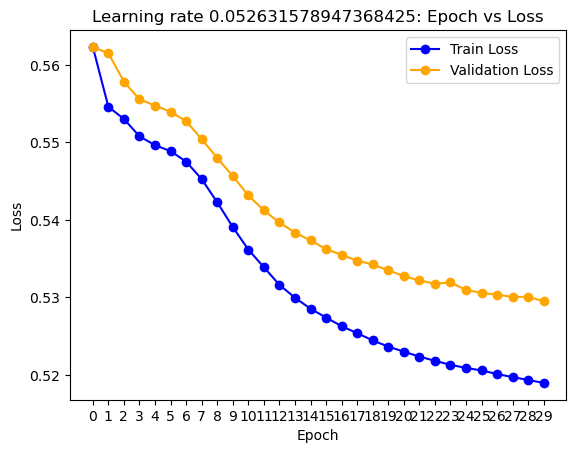

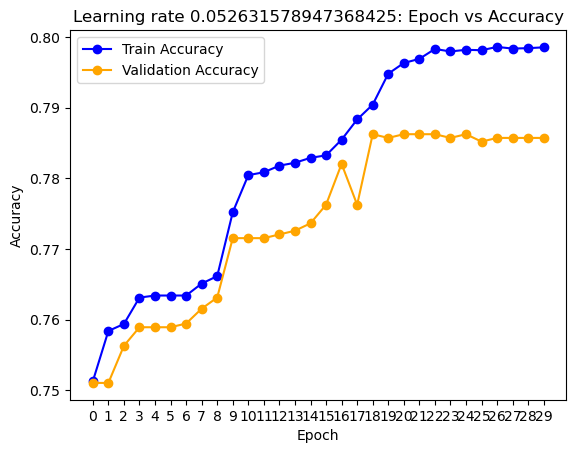

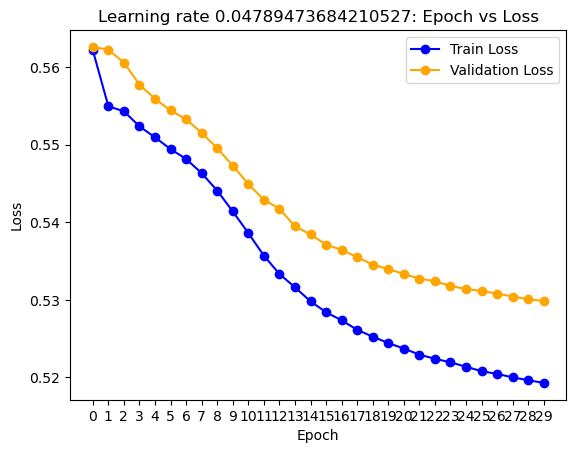

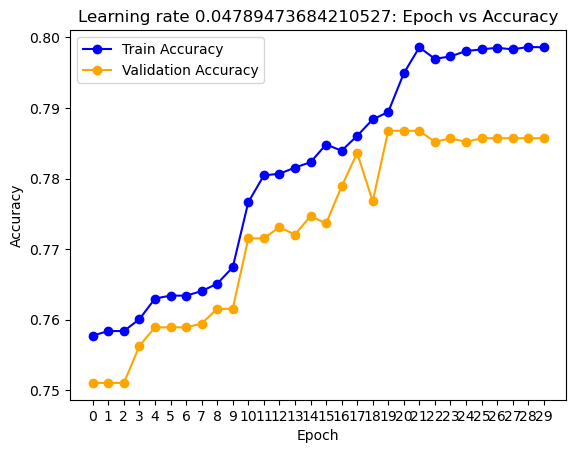

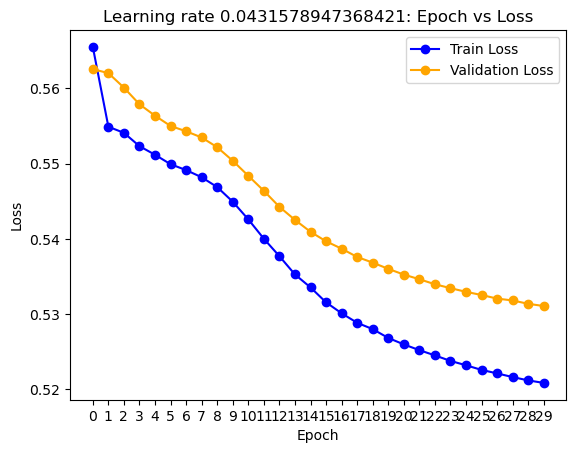

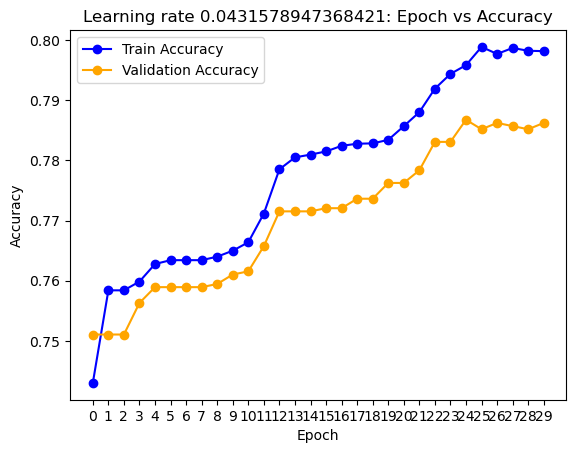

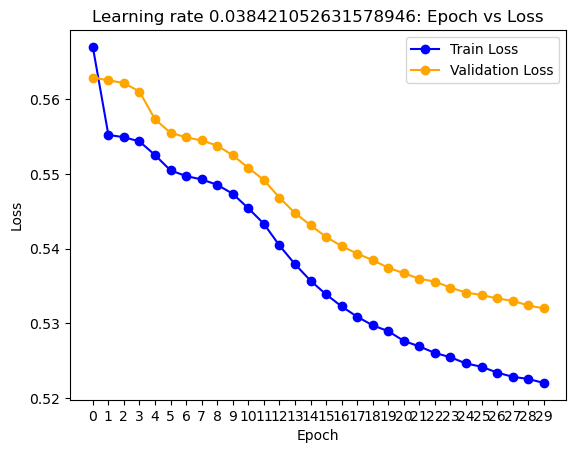

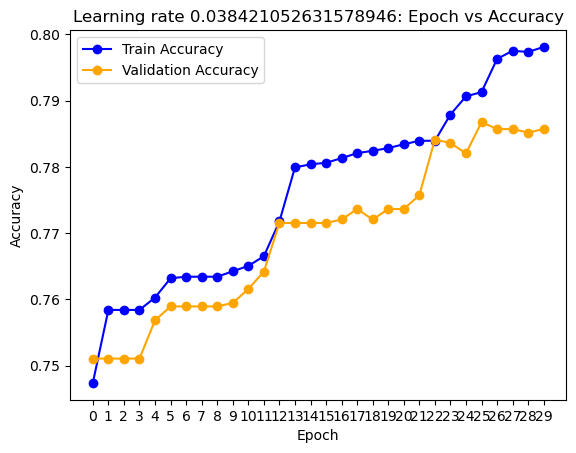

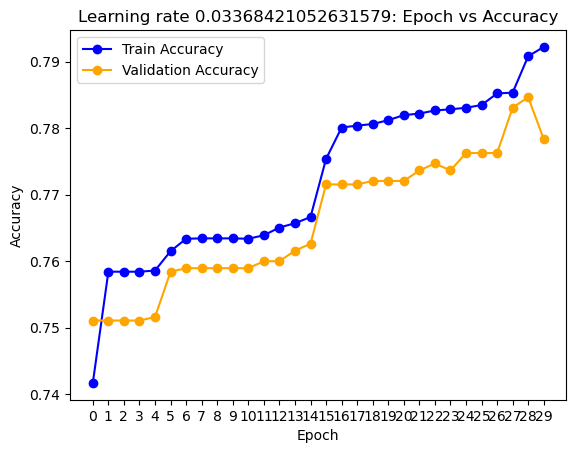

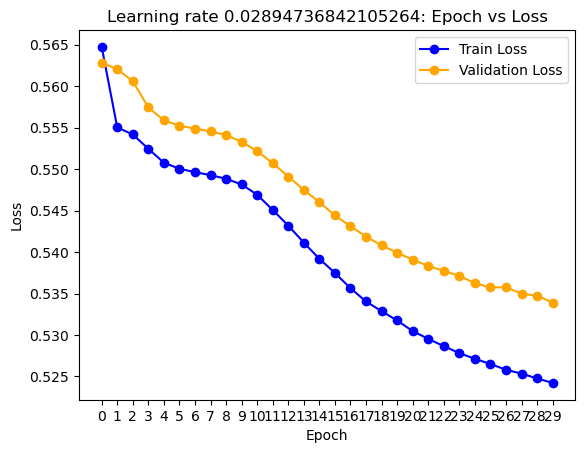

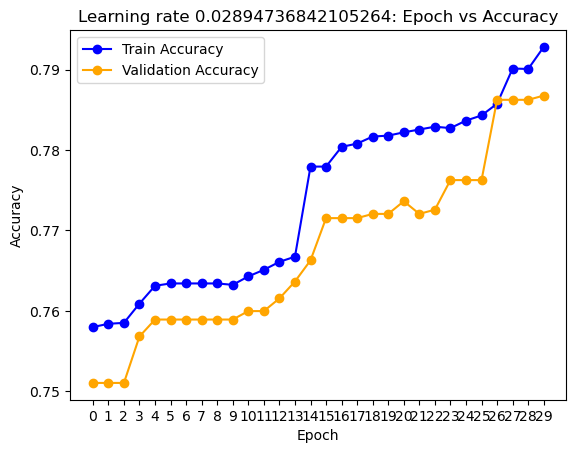

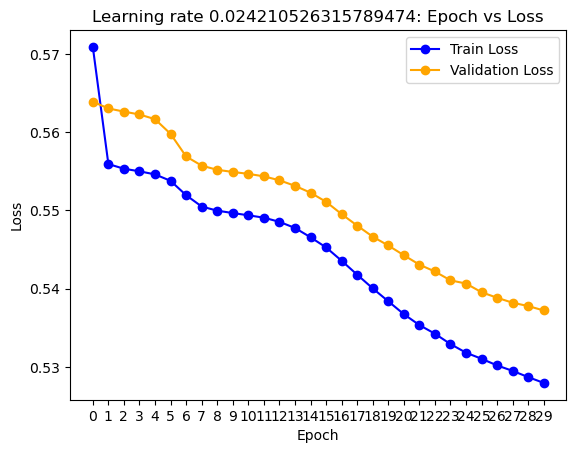

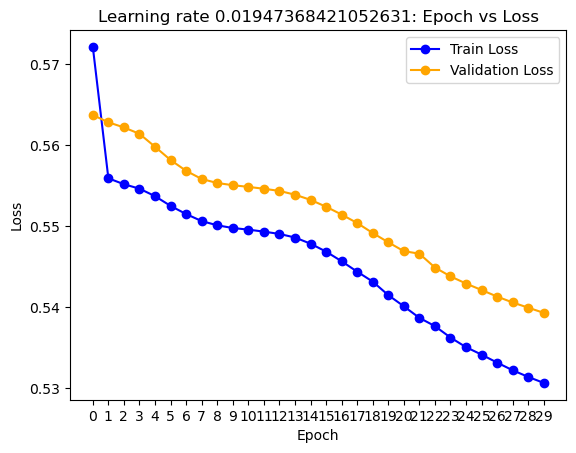

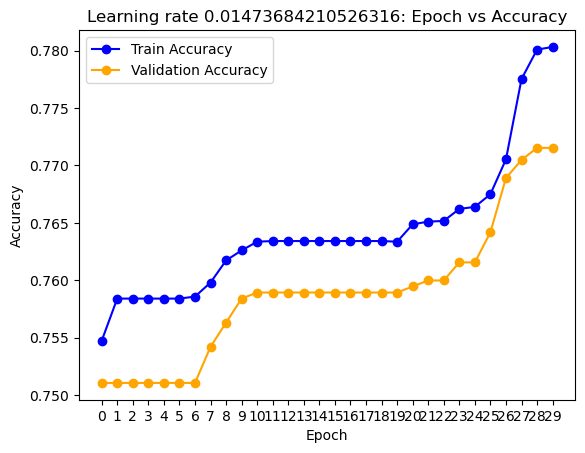

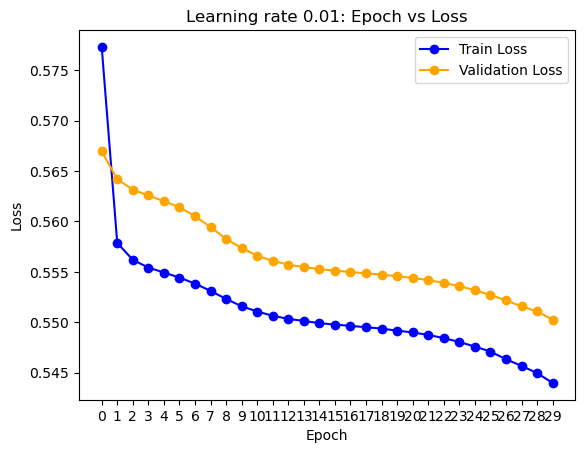

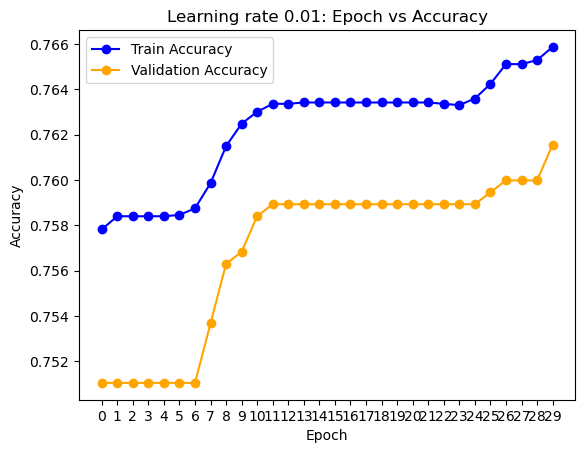

In [237]:
for value in values:
    plot_model_progress(value['train_losses'], value['val_losses'], value['epochs'], network_name=f'Learning rate {value["lr"]}')
    plot_model_progress(value['train_accs'], value['val_accs'], value['epochs'], network_name=f'Learning rate {value["lr"]}', loss=False)

In [238]:
train_df_2 = pd.DataFrame(values)

In [239]:
train_df = pd.concat([train_df, train_df_2])

train_df.head()

lr  epochs                                       train_losses  \
0  0.010000      10  [0.6046550883286035, 0.5596063097021473, 0.557...   
1  0.009526      10  [0.5917691125798581, 0.5593600780216615, 0.557...   
2  0.009053      10  [0.5779260592674141, 0.5584011682823523, 0.556...   
3  0.008579      10  [0.5782825648784637, 0.558745927775084, 0.5568...   
4  0.008105      10  [0.5873637368429953, 0.5592826760526913, 0.556...   

                                          val_losses  \
0  [0.5686369687318802, 0.5647712722420692, 0.563...   
1  [0.5685333833098412, 0.5649023503065109, 0.563...   
2  [0.5678040310740471, 0.5646777302026749, 0.563...   
3  [0.5680002793669701, 0.5649050250649452, 0.563...   
4  [0.5684493482112885, 0.5646726414561272, 0.563...   

                                          train_accs  \
0  [0.7071278581427904, 0.7583994400373308, 0.758...   
1  [0.7376341577228185, 0.7583994400373308, 0.758...   
2  [0.7573495100326645, 0.7583994400373308, 0.758...   
3  [0.7583994400373308, 0.7583994400373308, 0.758...   
4  [0.7586327578161456, 0.7583994400373308, 0.758...   

                                            val_accs  
0  [0.7510504201680672, 0.7510504201680672, 0.751...  
1  [0.7510504201680672, 0.7510504201680672, 0.751...  
2  [0.7510504201680672, 0.7510504201680672, 0.751...  
3  [0.7510504201680672, 0.7510504201680672, 0.751...  
4  [0.7510504201680672, 0.7510504201680672, 0.751...

In [241]:
train_df.to_pickle('test.pickle')


## Create a simple MLP

As the default tree has 3 layers, let's make a MLP with 3 linear layers and ReLU.
Please notice that making convolutions on tabular data does not make much sense even though it is technically possible.   

**TODO :** Explain why making convolutions on tabular data does not make much sense. Why do we use an MLP, not a CNN from the previous homework?
Answer:
With CNNs you assume that pixels near each other are realted which often/probably is not the case in tabular data.

In [242]:
import torch.nn as nn

class TabularNetwork(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        """ Initializes internal Module state. """
        super(TabularNetwork, self).__init__()
        self.network = nn.Sequential(
            # TODO : define 3 linear layer with sizes 
            # input_dim -> input_dim // 2 -> output_dim
            # using ReLU as nonlinearity
            nn.Linear(in_features=input_dim, out_features=input_dim // 2),
            nn.ReLU(),
            nn.Linear(in_features=input_dim // 2, out_features=input_dim // 4),
            nn.ReLU(),
            nn.Linear(in_features=input_dim // 4, out_features=output_dim),
            
        )
        
    def forward(self, x):
            x = torch.flatten(x, 1)
            x = x.to(torch.float)
            x = self.network(x)
            return x

In [294]:
## TODO : define model, optimizer, cross entropy loss,
## put model to the device, and train mode
## you can optionally try to add regularization 
lr=0.002
loss = nn.CrossEntropyLoss()
model=TabularNetwork(14, 2) 
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
model.to(device)
model.train()

TabularNetwork(
  (network): Sequential(
    (0): Linear(in_features=14, out_features=7, bias=True)
    (1): ReLU()
    (2): Linear(in_features=7, out_features=3, bias=True)
    (3): ReLU()
    (4): Linear(in_features=3, out_features=2, bias=True)
  )
)

In [295]:
## TODO : Train model
num_epochs = 30
train_losses, val_losses, train_accs, val_accs = run_training(model, optimizer, loss, device, num_epochs, train_loader, val_loader)

Train epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

Training:   0%|          | 0/67 [00:00<?, ?it/s]

Validation:   0%|          | 0/8 [00:00<?, ?it/s]

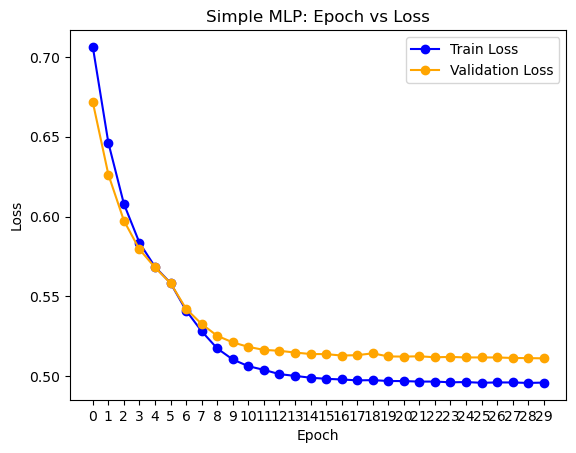

In [296]:
## todo - plot epochs vs loss with plot_model_progress
plot_model_progress(train_losses, val_losses, num_epochs, network_name='Simple MLP')

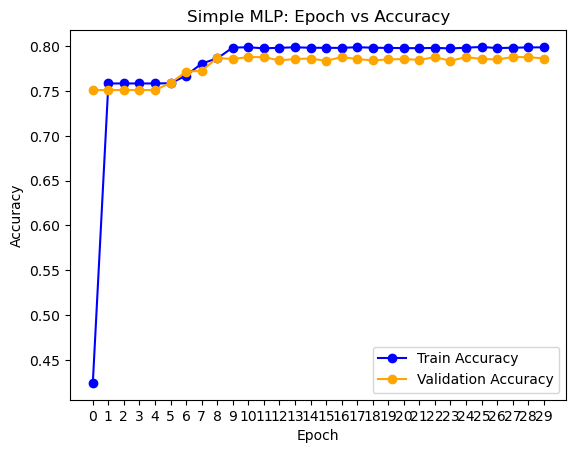

In [297]:
## todo - plot epochs and accuracy with plot_model_progress
plot_model_progress(train_accs, val_accs, num_epochs, loss=False, network_name='Simple MLP')

**TODO:** Did your network perform better or worse than the GradientBoostingClassifier on this dataset? Why? 


## Bonus tasks (optional)
* Try to use SGD instead of Adam as optimizer. What do you notice?
Here are different opinions on this topic:
  * https://codeahoy.com/questions/ds-interview/33/#:~:text=Adam%20tends%20to%20converge%20faster,converges%20to%20more%20optimal%20solutions.
  * https://shaoanlu.wordpress.com/2017/05/29/sgd-all-which-one-is-the-best-optimizer-dogs-vs-cats-toy-experiment/ 
  * https://datascience.stackexchange.com/questions/30344/why-not-always-use-the-adam-optimization-technique

* Try to make your MLP twice deeper. What do you notice? Why?

## Advanced topic to read about:
**Tools which may be helpful for data exploration:**
* df.describe() - returns some basic statistics for your dataset - https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html
* ydata-profiling (previous pandas-profiling) - generates interactive data exploration report: basic statistics, nans, correlations between different features - https://github.com/ydataai/ydata-profiling

**Tree libraries**
* XGBoost - XGBoost stands for “Extreme Gradient Boosting”, where the term “Gradient Boosting” originates from the paper Greedy Function Approximation: A Gradient Boosting Machine, by Friedman. https://xgboost.readthedocs.io/en/stable/tutorials/model.html
* LightGBM - industrial library for XGBoost from Miscrosoft. LightGBM is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient. https://lightgbm.readthedocs.io/en/v3.3.2/